# 🧬 Algoritmo Genético para Otimização Nutricional

Este notebook implementa um algoritmo genético para otimizar cardápios nutricionais, buscando combinações de alimentos que atendam às metas nutricionais diárias estabelecidas.

---

## Configuração e Carregamento de Dados


In [1]:
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt

# Carrega os dados dos alimentos
df_alimentos = pd.read_csv("alimentos.csv")

# Define semente para reprodutibilidade
random.seed(42)

In [ ]:
# Metas nutricionais diárias
METAS_NUTRICIONAIS = {
    "Energia..kcal.": 2000,
    "Proteína..g.": 75,
    "Carboidrato..g.": 275,
    "Lipídeos..g.": 70,
}

# Parâmetros do algoritmo genético
TAMANHO_POPULACAO = 30
NUMERO_GERACOES = 1000
TAXA_MUTACAO = 0.5
TAXA_ELITISMO = 0.1
TAMANHO_TORNEIO = 3
ALIMENTOS_POR_REFEICAO = 3

---

## Funções Básicas do Sistema


In [3]:
def gerar_cardapio_aleatorio(df):
    """Gera um cardápio aleatório."""
    alimentos = df["Descrição dos alimentos"].dropna().unique().tolist()
    return {
        "cafe": random.sample(alimentos, ALIMENTOS_POR_REFEICAO),
        "almoco": random.sample(alimentos, ALIMENTOS_POR_REFEICAO),
        "jantar": random.sample(alimentos, ALIMENTOS_POR_REFEICAO),
    }

def calcular_nutrientes(cardapio, df):
    """Calcula o total de nutrientes para um cardápio."""
    totais = {"Energia..kcal.": 0, "Proteína..g.": 0, "Carboidrato..g.": 0, "Lipídeos..g.": 0}
    
    for alimentos in cardapio.values():
        for alimento in alimentos:
            dados_alimento = df[df["Descrição dos alimentos"] == alimento]
            if not dados_alimento.empty:
                for nutriente in totais.keys():
                    valor = dados_alimento[nutriente].values[0]
                    if pd.notna(valor):
                        totais[nutriente] += valor
    return totais

def calcular_fitness(cardapio, df, metas):
    """Calcula o fitness (menor desvio é melhor)."""
    nutrientes = calcular_nutrientes(cardapio, df)
    fitness = 0
    for nutriente, meta in metas.items():
        fitness -= abs(nutrientes.get(nutriente, 0) - meta)
    return fitness


In [4]:
def selecao_torneio(populacao, fitnesses):
    """Seleciona indivíduos usando seleção por torneio."""
    selecionados = []
    for _ in range(len(populacao)):
        indices_torneio = random.sample(range(len(populacao)), TAMANHO_TORNEIO)
        indice_vencedor = max(indices_torneio, key=lambda i: fitnesses[i])
        selecionados.append(copy.deepcopy(populacao[indice_vencedor]))
    return selecionados

def cruzamento(pai1, pai2):
    """Cria descendentes através de cruzamento."""
    filho = {}
    for refeicao in ["cafe", "almoco", "jantar"]:
        filho[refeicao] = random.choice([pai1[refeicao], pai2[refeicao]]).copy()
    return filho

def mutar_refeicao(cardapio, df):
    """Mutação substituindo refeições inteiras."""
    if random.random() < TAXA_MUTACAO:
        alimentos = df["Descrição dos alimentos"].dropna().unique().tolist()
        refeicao = random.choice(["cafe", "almoco", "jantar"])
        cardapio[refeicao] = random.sample(alimentos, ALIMENTOS_POR_REFEICAO)
    return cardapio

def mutar_alimento(cardapio, df):
    """Mutação substituindo alimentos individuais."""
    if random.random() < TAXA_MUTACAO:
        alimentos = df["Descrição dos alimentos"].dropna().unique().tolist()
        refeicao = random.choice(["cafe", "almoco", "jantar"])
        indice_alimento = random.randint(0, ALIMENTOS_POR_REFEICAO - 1)
        cardapio[refeicao][indice_alimento] = random.choice(alimentos)
    return cardapio


---

## Algoritmo Genético


In [ ]:
def algoritmo_genetico(df, metas, populacao_inicial=None, usar_elitismo=False, tipo_mutacao="refeicao"):
    """Executa o algoritmo genético para encontrar cardápios ótimos."""
    
    # Usa população inicial fornecida ou gera uma nova
    if populacao_inicial is None:
        populacao = [gerar_cardapio_aleatorio(df) for _ in range(TAMANHO_POPULACAO)]
    else:
        # Cria cópia profunda para evitar modificar o original
        populacao = [copy.deepcopy(cardapio) for cardapio in populacao_inicial]
    
    historico_fitness = []
    
    for geracao in range(NUMERO_GERACOES):
        # Calculo fitness
        fitnesses = [calcular_fitness(cardapio, df, metas) for cardapio in populacao]
        historico_fitness.append(max(fitnesses))
        
        # Seleção
        selecionados = selecao_torneio(populacao, fitnesses)
        
        # Cria nova população
        nova_populacao = []
        
        # Elitismo: mantém os melhores indivíduos
        if usar_elitismo:
            quantidade_elite = max(1, int(TAMANHO_POPULACAO * TAXA_ELITISMO))
            indices_elite = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i], reverse=True)
            for i in indices_elite[:quantidade_elite]:
                nova_populacao.append(copy.deepcopy(populacao[i]))
        
        # Gera descendentes
        while len(nova_populacao) < TAMANHO_POPULACAO:
            pai1 = random.choice(selecionados)
            pai2 = random.choice(selecionados)
            
            filho1 = cruzamento(pai1, pai2)
            filho2 = cruzamento(pai2, pai1)
            
            # Mutação
            if tipo_mutacao == "refeicao":
                filho1 = mutar_refeicao(filho1, df)
                filho2 = mutar_refeicao(filho2, df)
            else:  # alimento
                filho1 = mutar_alimento(filho1, df)
                filho2 = mutar_alimento(filho2, df)
            
            nova_populacao.extend([filho1, filho2])
        
        populacao = nova_populacao[:TAMANHO_POPULACAO]
    
    # Retorna melhor solução
    fitnesses_finais = [calcular_fitness(cardapio, df, metas) for cardapio in populacao]
    melhor_indice = fitnesses_finais.index(max(fitnesses_finais))
    return populacao[melhor_indice], fitnesses_finais[melhor_indice], historico_fitness


---

## Funções de Visualização e Relatórios


In [6]:
def exibir_resultados(cardapio, df, metas, fitness):
    """Exibe os resultados do cardápio como uma lista."""
    print("Melhor cardápio:")
    for refeicao, alimentos in cardapio.items():
        print(f"- {refeicao}:")
        for alimento in alimentos:
            print(f"  • {alimento}")
    
    nutrientes = calcular_nutrientes(cardapio, df)
    print("\nNutrientes:")
    for nutriente, valor in nutrientes.items():
        meta = metas.get(nutriente, 0)
        print(f"- {nutriente}: {valor:.2f} (meta: {meta:.2f})")
    
    print(f"\nFitness final: {fitness:.2f}")

def plotar_fitness(historicos_fitness, rotulos):
    """Plota a evolução do fitness."""
    plt.figure(figsize=(15, 6))
    cores = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, (historico, rotulo) in enumerate(zip(historicos_fitness, rotulos)):
        plt.plot(range(1, len(historico) + 1), historico, 
                color=cores[i % len(cores)], linewidth=2, label=rotulo)
    
    plt.xlabel("Geração")
    plt.ylabel("Melhor Fitness")
    plt.title("Evolução do Melhor Fitness por Geração")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


---

## Experimentos e Análise Comparativa


In [7]:
# Gera população inicial compartilhada para comparação justa
print("Gerando população inicial compartilhada...")
populacao_inicial_compartilhada = [gerar_cardapio_aleatorio(df_alimentos) for _ in range(TAMANHO_POPULACAO)]
print(f"População inicial gerada com {len(populacao_inicial_compartilhada)} indivíduos.")

Gerando população inicial compartilhada...
População inicial gerada com 30 indivíduos.


### 🔹 Experimento 1: Algoritmo Genético Básico

Implementação padrão com:
- Seleção por torneio
- Mutação por refeição completa
- Sem elitismo


In [8]:
# Experimento 1: Algoritmo genético básico
print("=== Algoritmo Genético Básico ===\n")
melhor_basico, fitness_basica, historico_basico = algoritmo_genetico(
    df_alimentos, METAS_NUTRICIONAIS, 
    populacao_inicial=populacao_inicial_compartilhada,
    usar_elitismo=False, tipo_mutacao="refeicao"
)
exibir_resultados(melhor_basico, df_alimentos, METAS_NUTRICIONAIS, fitness_basica)


=== Algoritmo Genético Básico ===

Melhor cardápio:
- cafe:
  • Carne, bovina, contra-filé, com gordura, cru
  • Leite, condensado
  • Queijo, requeijão, cremoso
- almoco:
  • Achocolatado, pó
  • Brócolis, cru
  • Maniçoba
- jantar:
  • Lingüiça, frango, grelhada
  • Arroz, tipo 1, cozido
  • Glicose de milho

Nutrientes:
- Energia..kcal.: 2000.00 (meta: 2000.00)
- Proteína..g.: 77.00 (meta: 75.00)
- Carboidrato..g.: 265.50 (meta: 275.00)
- Lipídeos..g.: 72.70 (meta: 70.00)

Fitness final: -14.20


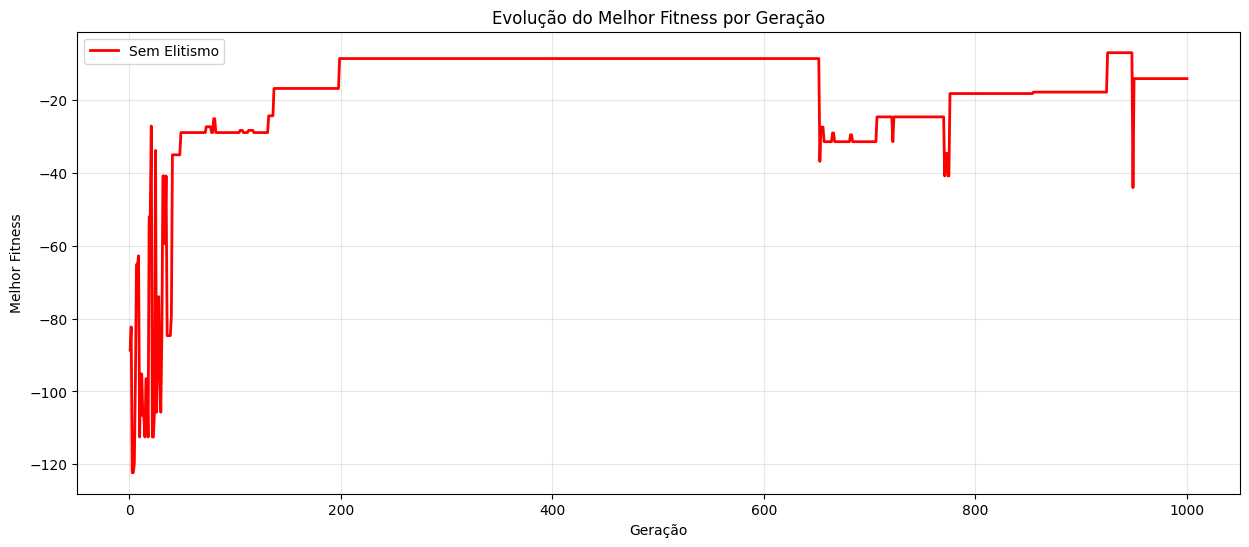

In [9]:
plotar_fitness(
    [historico_basico],
    ["Sem Elitismo"]
)

### 🔹 Experimento 2: Algoritmo com Elitismo

Variação que preserva os 10% melhores indivíduos de cada geração:
- Mantém estratégia de seleção por torneio
- Mutação por refeição completa
- **Com elitismo** (10% dos melhores preservados)


In [10]:
# Experimento 2: Com elitismo
print("=== Algoritmo Genético com Elitismo ===\n")
melhor_elitismo, fitness_elitismo, historico_elitismo = algoritmo_genetico(
    df_alimentos, METAS_NUTRICIONAIS, 
    populacao_inicial=populacao_inicial_compartilhada,
    usar_elitismo=True, tipo_mutacao="refeicao"
)
exibir_resultados(melhor_elitismo, df_alimentos, METAS_NUTRICIONAIS, fitness_elitismo)


=== Algoritmo Genético com Elitismo ===

Melhor cardápio:
- cafe:
  • Pão, aveia, forma
  • Farinha, de mandioca, torrada
  • Chá, erva-doce, infusão 5%
- almoco:
  • Lingüiça, porco, crua
  • Refrigerante, tipo água tônica
  • Pastel, de carne, frito
- jantar:
  • Soja, extrato solúvel, natural, fluido
  • Biscoito, doce, recheado com chocolate
  • Carne, bovina, bucho, cozido

Nutrientes:
- Energia..kcal.: 1999.00 (meta: 2000.00)
- Proteína..g.: 70.20 (meta: 75.00)
- Carboidrato..g.: 275.80 (meta: 275.00)
- Lipídeos..g.: 69.40 (meta: 70.00)

Fitness final: -7.20


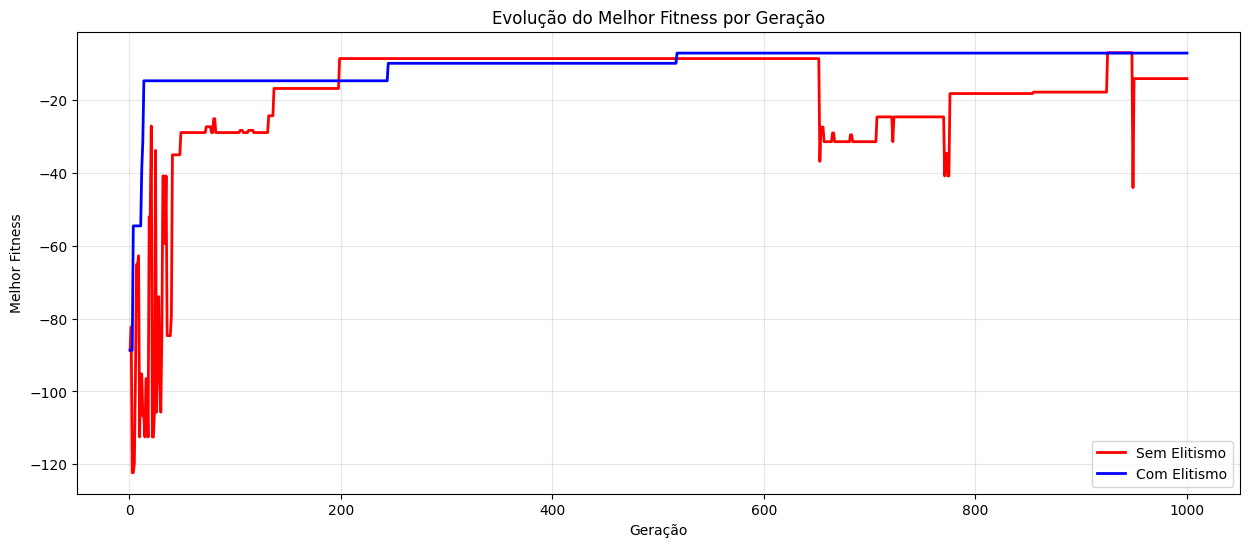

In [11]:
plotar_fitness(
    [historico_basico, historico_elitismo],
    ["Sem Elitismo", "Com Elitismo"]
)

### 🔹 Experimento 3: Elitismo + Mutação Granular

Versão mais refinada com mutação por alimento individual:
- Seleção por torneio
- **Mutação por alimento** (mais granular)
- **Com elitismo** (10% dos melhores preservados)


In [12]:
# Experimento 3: Elitismo + mutação por alimento
print("=== Algoritmo Genético com Elitismo e Mutação por Alimento ===\n")
melhor_mut_alimento, fitness_mut_alimento, historico_mut_alimento = algoritmo_genetico(
    df_alimentos, METAS_NUTRICIONAIS, 
    populacao_inicial=populacao_inicial_compartilhada,
    usar_elitismo=True, tipo_mutacao="alimento"
)
exibir_resultados(melhor_mut_alimento, df_alimentos, METAS_NUTRICIONAIS, fitness_mut_alimento)


=== Algoritmo Genético com Elitismo e Mutação por Alimento ===

Melhor cardápio:
- cafe:
  • Rabanete, cru
  • Maionese, tradicional com ovos
  • Arroz, tipo 2, cru
- almoco:
  • Beterraba, crua
  • Bacalhau, salgado, refogado
  • Estrogonofe de frango
- jantar:
  • Chocolate, meio amargo
  • Açúcar, mascavo
  • Quibe, assado

Nutrientes:
- Energia..kcal.: 2000.00 (meta: 2000.00)
- Proteína..g.: 73.00 (meta: 75.00)
- Carboidrato..g.: 274.20 (meta: 275.00)
- Lipídeos..g.: 75.30 (meta: 70.00)

Fitness final: -8.10


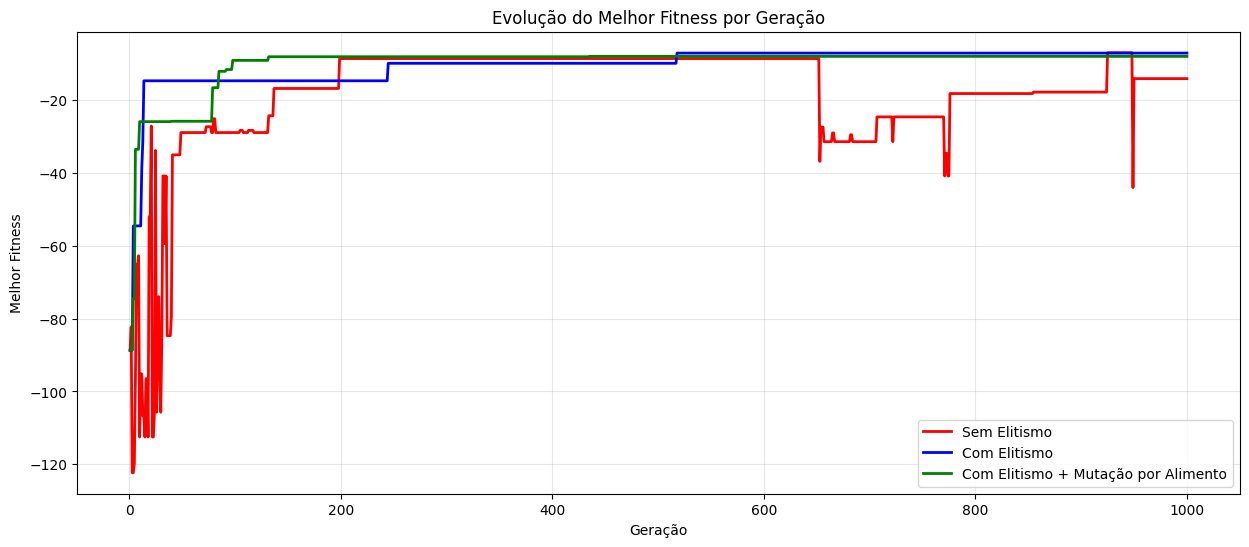

In [13]:
plotar_fitness(
    [historico_basico, historico_elitismo, historico_mut_alimento],
    ["Sem Elitismo", "Com Elitismo", "Com Elitismo + Mutação por Alimento"]
)


---

## Resumo e Conclusões


In [14]:
# Resumo comparativo
print("" + "=" * 60)
print("RESUMO COMPARATIVO")
print("=" * 60)
print("🔬 NOTA: Todos os experimentos usaram a MESMA população inicial")
print("   para garantir comparação justa entre os algoritmos!")
print("=" * 60)

resultados = [
    ("Básico", melhor_basico, fitness_basica),
    ("Com Elitismo", melhor_elitismo, fitness_elitismo),
    ("Elitismo + Mutação por Alimento", melhor_mut_alimento, fitness_mut_alimento),
]

for nome, cardapio, fitness in resultados:
    print(f"{nome}: Fitness = {fitness:.2f}")
    nutrientes = calcular_nutrientes(cardapio, df_alimentos)
    for nutriente, valor_atual in nutrientes.items():
        meta = METAS_NUTRICIONAIS[nutriente]
        desvio = abs(valor_atual - meta)
        precisao = max(0, (1 - desvio / meta) * 100)
        print(f"  {nutriente}: {valor_atual:.1f}/{meta:.1f} ({precisao:.1f}%)")
    print("-" * 40)

RESUMO COMPARATIVO
🔬 NOTA: Todos os experimentos usaram a MESMA população inicial
   para garantir comparação justa entre os algoritmos!
Básico: Fitness = -14.20
  Energia..kcal.: 2000.0/2000.0 (100.0%)
  Proteína..g.: 77.0/75.0 (97.3%)
  Carboidrato..g.: 265.5/275.0 (96.5%)
  Lipídeos..g.: 72.7/70.0 (96.1%)
----------------------------------------
Com Elitismo: Fitness = -7.20
  Energia..kcal.: 1999.0/2000.0 (100.0%)
  Proteína..g.: 70.2/75.0 (93.6%)
  Carboidrato..g.: 275.8/275.0 (99.7%)
  Lipídeos..g.: 69.4/70.0 (99.1%)
----------------------------------------
Elitismo + Mutação por Alimento: Fitness = -8.10
  Energia..kcal.: 2000.0/2000.0 (100.0%)
  Proteína..g.: 73.0/75.0 (97.3%)
  Carboidrato..g.: 274.2/275.0 (99.7%)
  Lipídeos..g.: 75.3/70.0 (92.4%)
----------------------------------------
